In [74]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from src import utils, nlp_utils
from bs4 import BeautifulSoup
import itertools

import nltk
from nltk.corpus import stopwords

from datetime import datetime
from wordcloud import WordCloud

from collections import Counter

In [3]:
# nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\morga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Wall Street Forum

## EDA - Raw Data

In [65]:
wallstreet = pd.read_csv('data/wallstreet.csv')

In [66]:
wallstreet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45372 entries, 0 to 45371
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   postID                45372 non-null  int64 
 1   threadID              45372 non-null  int64 
 2   threadTitle           45370 non-null  object
 3   URL                   45372 non-null  object
 4   subforum              45372 non-null  object
 5   authorName            45372 non-null  object
 6   postAuthorMembership  45372 non-null  object
 7   postAuthorJoinDate    45372 non-null  object
 8   authorReputation      45372 non-null  int64 
 9   postDate              45372 non-null  object
 10  postSequence          45372 non-null  int64 
 11  likes                 45372 non-null  int64 
 12  flatContent           45372 non-null  object
 13  contentWithHTMLTag    45372 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.8+ MB


In [115]:
wallstreet.head()

,postID,threadID,threadTitle,URL,subforum,authorName,postAuthorMembership,postAuthorJoinDate,authorReputation,postDate,postSequence,likes,flatContent,contentWithHTMLTag
0,6,5,Hi,http://x7bwsmcore5fmx56.onion/viewtopic.php?id=5,Introductions,Punka421,New member,2016-10-26,-3,2016-10-26 13:58:36,1,0,\nJust thought I'd introduce myself. I am new ...,"<div class=""entry-content"">\n<p>Just thought I..."
1,7,5,Hi,http://x7bwsmcore5fmx56.onion/viewtopic.php?id=5,Introductions,WSM,Administrator,2016-10-02,66,2016-10-26 14:04:04,2,0,\nHello Nice to see you here!Regards\n,"<div class=""entry-content"">\n<p>Hello <img alt..."
2,8,6,WSM Updates - Changelog (Page 1 of 4),http://x7bwsmcore5fmx56.onion/viewtopic.php?id=6,Announcements,WSM,Administrator,2016-10-02,74,2016-10-26 16:54:27,1,0,\nHello everyone.I would like to tell you that...,"<div class=""entry-content"">\n<p>Hello everyone..."
3,11,5,Hi,http://x7bwsmcore5fmx56.onion/viewtopic.php?id=5,Introductions,Estrazy,Banned,2016-10-27,0,2016-10-27 14:00:16,3,0,\nHello Punka! nice to meet you!As you asked h...,"<div class=""entry-content"">\n<p>Hello Punka! n..."
4,13,6,WSM Updates - Changelog (Page 1 of 4),http://x7bwsmcore5fmx56.onion/viewtopic.php?id=6,Announcements,WSM,Administrator,2016-10-02,74,2016-11-02 15:42:27,2,0,"\nChangelog from Wednesday, 2nd November 2016F...","<div class=""entry-content"">\n<h5>Changelog fro..."


In [67]:
total_num_posts_wall = wallstreet.shape[0] 
print('# of Postings: ', total_num_posts_wall)
print('# of Unique Threads : ', len(wallstreet['threadID'].unique()))
print('# of Unique Subforums : ', len(wallstreet['subforum'].unique()))
print('# of Unique Authors : ', len(wallstreet['authorName'].unique()))
print('# of Membership Types : ', len(wallstreet['postAuthorMembership'].unique()))

# of Postings:  45372
# of Unique Threads :  8755
# of Unique Subforums :  40
# of Unique Authors :  5533
# of Membership Types :  8


In [68]:
wall_authors = pd.DataFrame(wallstreet['authorName'].value_counts()).reset_index()
wall_authors.columns = ['author','num_postings']
wall_authors['prcnt_total_posts'] = wall_authors['num_postings'] / total_num_posts_wall
wall_authors.head(10)

,author,num_postings,prcnt_total_posts
0,med3l1n,4889,0.107754
1,6LACK,1500,0.033060
2,leaguemode,1146,0.025258
3,ExpectUS,1113,0.024531
4,PurityRing,1111,0.024486
5,BonesKoopa,476,0.010491
6,Icepapi,446,0.009830
7,code48k,379,0.008353
8,deusxmacina,354,0.007802
9,dabbingtimes,334,0.007361


In [69]:
wall_threads = pd.DataFrame(wallstreet['threadTitle'].value_counts()).reset_index()
wall_threads.columns = ['thread_topic','num_postings']
wall_threads['prcnt_total_posts'] = wall_threads['num_postings'] / total_num_posts_wall
wall_threads.head(10)

,thread_topic,num_postings,prcnt_total_posts
0,GozNym 2.0 Banking Bot (Page 2 of 3),75,0.001653
1,GozNym 2.0 Banking Bot (Page 1 of 3),75,0.001653
2,[Price & Version update] BTC ATM Malware,73,0.001609
3,GozNym 2.0 Banking Bot (Page 3 of 3),56,0.001234
4,Hello,52,0.001146
5,ANZ AU Bank accounts with security Q&A! (Page ...,50,0.001102
6,US Tax Refund: 2018 Tax W2 Forms With AGI & DO...,50,0.001102
7,ANZ AU Bank accounts with security Q&A! (Page ...,50,0.001102
8,US Tax Refund: 2018 Tax W2 Forms With AGI & DO...,50,0.001102
9,CASHAPP GUIDE,50,0.001102


In [9]:
wall_subforums = pd.DataFrame(wallstreet['subforum'].value_counts()).reset_index()
wall_subforums.columns = ['subforum','num_postings']
wall_subforums['prcnt_total_posts'] = wall_subforums['num_postings'] / total_num_posts_wall
wall_subforums.head(10)

,subforum,num_postings,prcnt_total_posts
0,Fraud,12277,0.270585
1,General Questions,5225,0.115159
2,Carding Stuff,3836,0.084546
3,Services,2973,0.065525
4,Cannabis,2431,0.053579
5,Introductions,2418,0.053293
6,Counterfeits,1727,0.038063
7,Stimulants,1537,0.033876
8,Announcements,1507,0.033214
9,Digital goods,1443,0.031804


In [10]:
wall_joindate = pd.DataFrame(wallstreet['postAuthorJoinDate'].value_counts()).reset_index()
wall_joindate.columns = ['join_date','count']
wall_joindate['prcnt_total_posts'] = wall_joindate['count'] / total_num_posts_wall
wall_joindate.head(10)

,join_date,count,prcnt_total_posts
0,Despacitoland,4889,0.107754
1,G,1500,0.033060
2,2017-11-06,1227,0.027043
3,2018-01-10,1146,0.025258
4,InterWebz,1113,0.024531
5,2017-07-27,524,0.011549
6,2018-03-03,498,0.010976
7,2017-11-09,427,0.009411
8,2018-05-06,415,0.009147
9,2017-10-17,403,0.008882


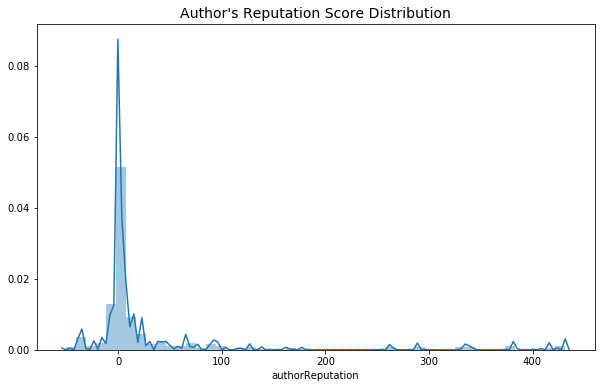

In [11]:
# Max value ~ 5,400.
constraint = 500
reputation = wallstreet[wallstreet['authorReputation'] < constraint]['authorReputation']
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(reputation)
ax.set_title("Author's Reputation Score Distribution", fontsize=14);

C:\Users\morga\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


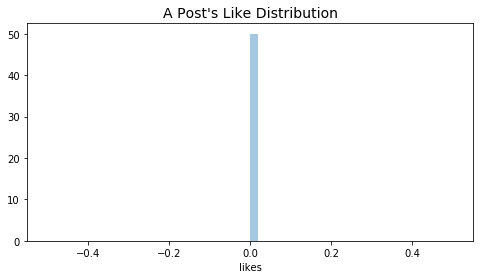

In [12]:
constraint = 100
likes = wallstreet[wallstreet['likes'] < constraint]['likes']
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.distplot(likes)
ax.set_title("A Post's Like Distribution", fontsize=14);

---
## Data Processing / Feature Engineering

In [75]:
stop_words = stopwords.words("english")
stopwords_dict = Counter(stop_words)

In [76]:
print(stopwords_dict)

Counter({'i': 1, 'me': 1, 'my': 1, 'myself': 1, 'we': 1, 'our': 1, 'ours': 1, 'ourselves': 1, 'you': 1, "you're": 1, "you've": 1, "you'll": 1, "you'd": 1, 'your': 1, 'yours': 1, 'yourself': 1, 'yourselves': 1, 'he': 1, 'him': 1, 'his': 1, 'himself': 1, 'she': 1, "she's": 1, 'her': 1, 'hers': 1, 'herself': 1, 'it': 1, "it's": 1, 'its': 1, 'itself': 1, 'they': 1, 'them': 1, 'their': 1, 'theirs': 1, 'themselves': 1, 'what': 1, 'which': 1, 'who': 1, 'whom': 1, 'this': 1, 'that': 1, "that'll": 1, 'these': 1, 'those': 1, 'am': 1, 'is': 1, 'are': 1, 'was': 1, 'were': 1, 'be': 1, 'been': 1, 'being': 1, 'have': 1, 'has': 1, 'had': 1, 'having': 1, 'do': 1, 'does': 1, 'did': 1, 'doing': 1, 'a': 1, 'an': 1, 'the': 1, 'and': 1, 'but': 1, 'if': 1, 'or': 1, 'because': 1, 'as': 1, 'until': 1, 'while': 1, 'of': 1, 'at': 1, 'by': 1, 'for': 1, 'with': 1, 'about': 1, 'against': 1, 'between': 1, 'into': 1, 'through': 1, 'during': 1, 'before': 1, 'after': 1, 'above': 1, 'below': 1, 'to': 1, 'from': 1, 'up':

In [125]:
def parse_clean(text):
    '''
   
    Args:
        
        
    Return:
        
    '''
    
    text = BeautifulSoup(text, 'html.parser').get_text().lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r"[^\w\s]", '', text)
    #text = re.sub(r'\w*\d\w*', '', text)
    
    return text

def tokenize_lemmatize(text):
    '''
    
    
    Args:
        comment (str) : Content of the author's post in Wall Street Market.
        
    Return:
        lem_tokens (arr) : The cleaned, tokenized and lemmetized version of comment.
        
    '''
    
    
    
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords_dict]
    
    wordnet_lemma = nltk.WordNetLemmatizer()
    lem_tokens = [wordnet_lemma.lemmatize(t) for t in tokens]
    
    return lem_tokens

In [126]:
def prep_text_for_wordcloud(text):
    '''
   
    Args:
        
        
    Return:
        
    '''
    #punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
    text = BeautifulSoup(text, 'html.parser').get_text().lower()
    text = re.sub(r'\n', ' ', text)
    # remove url address
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r"[^\w\s]", '', text)
    # text = re.sub(r'\w*\d\w*', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords_dict]
    joined_tokens = ' '.join(tokens)
    
    return joined_tokens

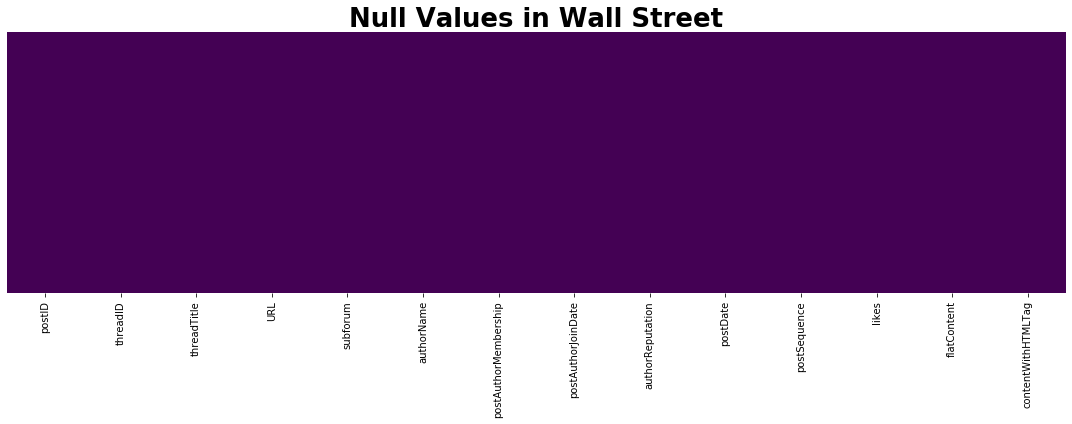

In [15]:
utils.plot_null_val_heatmap(wallstreet, 'Null Values in Wall Street', (15,6))

In [79]:
wallstreet_v2 = wallstreet.copy()

In [80]:
wallstreet_v2['post_date_dt'] = wallstreet_v2['postDate'].apply(utils.fix_postdate_col)
wallstreet_v2['author_join_date'] = wallstreet_v2.apply(lambda x: utils.fix_author_join_date_col(x['postAuthorJoinDate'], x['postAuthorMembership'], x['post_date_dt']), axis=1)
wallstreet_v2['num_days_member_when_posted'] = wallstreet_v2['post_date_dt'].dt.date - wallstreet_v2['author_join_date'].dt.date
wallstreet_v2['num_days_member_when_posted'] = wallstreet_v2['num_days_member_when_posted'].dt.days

In [81]:
cols_to_drop = ['URL', 'likes', 'postDate', 'postAuthorJoinDate']
wallstreet_v2.drop(cols_to_drop, axis=1, inplace=True)

In [82]:
wallstreet_v3 = wallstreet_v2.copy()

In [127]:
wallstreet_v3['wordcloud_text'] = wallstreet_v3['contentWithHTMLTag'].apply(prep_text_for_wordcloud)

In [128]:
wallstreet_v3['cleaned_text'] = wallstreet_v3['contentWithHTMLTag'].apply(parse_clean)
wallstreet_v3['lemmatized_tokens'] = wallstreet_v3['cleaned_text'].apply(tokenize_lemmatize)

In [129]:
wallstreet_v3.shape

(45372, 16)

In [130]:
wallstreet_v3.head()

,postID,threadID,threadTitle,subforum,authorName,postAuthorMembership,authorReputation,postSequence,flatContent,contentWithHTMLTag,post_date_dt,author_join_date,num_days_member_when_posted,wordcloud_text,cleaned_text,lemmatized_tokens
0,6,5,Hi,Introductions,Punka421,New member,-3,1,\nJust thought I'd introduce myself. I am new ...,"<div class=""entry-content"">\n<p>Just thought I...",2016-10-26 13:58:36,2016-10-26,0.0,thought id introduce new communities trying le...,just thought id introduce myself i am new to ...,"[thought, id, introduce, new, community, tryin..."
1,7,5,Hi,Introductions,WSM,Administrator,66,2,\nHello Nice to see you here!Regards\n,"<div class=""entry-content"">\n<p>Hello <img alt...",2016-10-26 14:04:04,2016-10-02,24.0,hello nice see hereregards,hello nice to see you hereregards,"[hello, nice, see, hereregards]"
2,8,6,WSM Updates - Changelog (Page 1 of 4),Announcements,WSM,Administrator,74,1,\nHello everyone.I would like to tell you that...,"<div class=""entry-content"">\n<p>Hello everyone...",2016-10-26 16:54:27,2016-10-02,24.0,hello everyonei would like tell weve implement...,hello everyonei would like to tell you that w...,"[hello, everyonei, would, like, tell, weve, im..."
3,11,5,Hi,Introductions,Estrazy,Banned,0,3,\nHello Punka! nice to meet you!As you asked h...,"<div class=""entry-content"">\n<p>Hello Punka! n...",2016-10-27 14:00:16,2016-10-27,0.0,hello punka nice meet youas asked stay secure ...,hello punka nice to meet youas you asked how ...,"[hello, punka, nice, meet, youas, asked, stay,..."
4,13,6,WSM Updates - Changelog (Page 1 of 4),Announcements,WSM,Administrator,74,2,"\nChangelog from Wednesday, 2nd November 2016F...","<div class=""entry-content"">\n<h5>Changelog fro...",2016-11-02 15:42:27,2016-10-02,31.0,changelog wednesday 2nd november 2016fixed lot...,changelog from wednesday 2nd november 2016fix...,"[changelog, wednesday, 2nd, november, 2016fixe..."


In [131]:
wallstreet_v3.tail()

,postID,threadID,threadTitle,subforum,authorName,postAuthorMembership,authorReputation,postSequence,flatContent,contentWithHTMLTag,post_date_dt,author_join_date,num_days_member_when_posted,wordcloud_text,cleaned_text,lemmatized_tokens
45367,71451,20321,Opening Leases,Fraud,24kings,Member,-1,1,\ni am planning on opening a few leases in a m...,"<div class=""entry-content"">\n<p>i am planning ...",2018-11-14 17:33:55,2018-05-13,185.0,planning opening leases middleclass community ...,i am planning on opening a few leases in a mi...,"[planning, opening, lease, middleclass, commun..."
45368,71454,20321,Opening Leases,Fraud,JGX7TRE,New member,0,2,\ndepends on if the landlord does a credit che...,"<div class=""entry-content"">\n<p>depends on if ...",2018-11-14 18:20:27,2018-11-14,0.0,depends landlord credit check landlords rent g...,depends on if the landlord does a credit chec...,"[depends, landlord, credit, check, landlord, r..."
45369,71455,19423,"Utility bills, bank statements and European PP...",Fraud,makarich,New member,0,2,\nDo you make UK documents? Can you do specifi...,"<div class=""entry-content"">\n<p>Do you make UK...",2018-11-14 18:21:54,2018-11-14,0.0,make uk documents specific companies banks sta...,do you make uk documents can you do specific ...,"[make, uk, document, specific, company, bank, ..."
45370,71457,20187,Need legit USA CVV seller,Digital goods,fuckshit123,New member,0,8,\nPlease stop allowing identity theft before y...,"<div class=""entry-content"">\n<p>Please stop al...",2018-11-14 19:01:06,2018-11-12,2.0,please stop allowing identity theft concern ra...,please stop allowing identity theft before yo...,"[please, stop, allowing, identity, theft, conc..."
45371,71458,20321,Opening Leases,Fraud,ExpectUS,Vendor,1330,3,\n24kings wrote:i am planning on opening a few...,"<div class=""entry-content"">\n<div class=""quote...",2018-11-14 19:04:50,NaT,NaN,24kings wrotei planning opening leases middlec...,24kings wrotei am planning on opening a few l...,"[24kings, wrotei, planning, opening, lease, mi..."


In [132]:
wallstreet_v3.to_csv('data/wallstreet_master.csv', index=False)

---
# EDA using Engineering Features

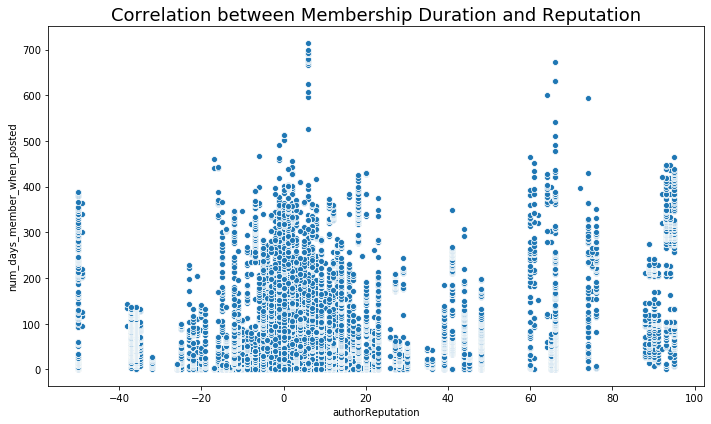

In [133]:
rep_limit = 500
excl_rep_outliers = wallstreet_v3[wallstreet_v3['authorReputation'] < rep_limit]

plt.figure(figsize=(10,6))

sns.scatterplot(y='num_days_member_when_posted', x='authorReputation', data=excl_rep_outliers)
plt.title('Correlation between Membership Duration and Reputation', fontsize=18)
plt.tight_layout();

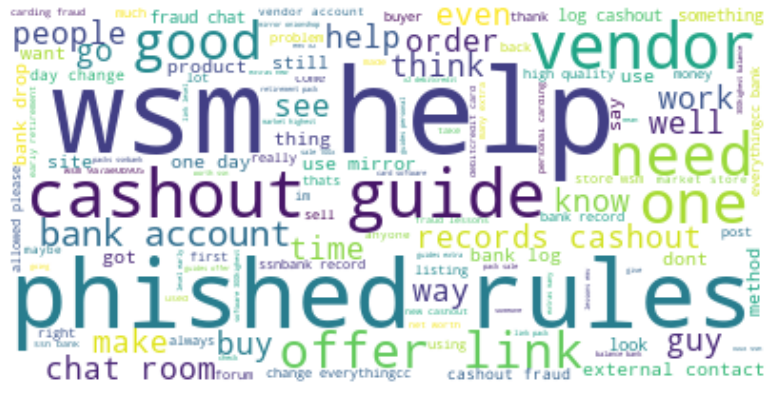

In [134]:
max_words=100000
joined_wordcloud_text = ' '.join(wallstreet_v3['wordcloud_text'])

wordcloud = WordCloud(background_color='white', max_words=max_words, contour_color='steelblue')
wordcloud.generate(joined_wordcloud_text)

plt.figure(figsize=(20,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

In [135]:
pd.Series(joined_wordcloud_text.split(' ')).value_counts()

get            16275
market         10591
wsm            10302
vendor          9975
bank            9908
               ...  
llevaba            1
cardado            1
replacedyes        1
kamikazee          1
ltd403960          1
Length: 110282, dtype: int64